In [547]:
import evaluate 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from transformers import BertTokenizerFast, BertForSequenceClassification
from transformers import DataCollatorForTokenClassification
from datasets import load_dataset
from transformers import AutoModelForTokenClassification
from transformers import TrainingArguments
from transformers import Trainer
from transformers import pipeline

# Read Data

In [402]:
df = pd.read_json('last/all.jsonl', orient='records', lines=True)
copy = pd.read_json('last/all.jsonl', orient='records', lines=True)

In [573]:
d = pd.read_json('last/all.jsonl', orient='records', lines=True)

# Base Model 

In [108]:
model_path = "dbmdz/bert-base-turkish-128k-uncased"
tokenizer = BertTokenizerFast.from_pretrained(model_path, max_len=512)

# Data Pre-Processing

In [338]:
def removeDegreeLabels(data):
    for item in range(len(data.label)):
        for lbl in data.iloc[item].label:
            if(lbl[2] == "Derece 1" or lbl[2] == "Derece 2" or lbl[2] == "Derece 3"): 
                data.iloc[item].label.remove(lbl)
    return data

In [404]:
new = removeDegreeLabels(copy)

In [174]:
def getTokenizedLabels(data):
    labels_list = []
    for text, doccano_label_list in zip(data['text'], data['label']):
        encoding = tokenizer(text, return_offsets_mapping=True)
        labels = [None] * len(encoding["offset_mapping"])
        doccano_label_index = 0
        for index, token_tupple in enumerate(encoding["offset_mapping"]):
            doccano_label = doccano_label_list[doccano_label_index]
            if(token_tupple == (0,0)): continue

            if(token_tupple[0] > doccano_label[1] and ((doccano_label_index+1) != len(doccano_label_list))):
                doccano_label_index += 1
                doccano_label = doccano_label_list[doccano_label_index]

            if(doccano_label[0] <= token_tupple[0] <= doccano_label[1]):
                labels[index] = doccano_label[2]
            else:
                labels[index] = 'O'
        labels_list.append(labels)
    return pd.Series(labels_list)

In [398]:
def enumLabels(labels):
    label2id = {None:-100, 'O':0, 'Destek':1, 'Direnç':2, 'Hedef':3, 'Pozitif Yorum':4, 'Negatif Yorum':5, 'Vade':6}
    id2label = {v:k for k,v in label2id.items()}
    bert_labels_id = bert_labels.map(lambda x: [label2id[y] for y in x])
    return bert_labels_id


In [405]:
bert_labels = getTokenizedLabels(new)

In [406]:
bert_labels_id = enumLabels(bert_labels)

# Dataset

In [407]:
new['tokens'] = new.text.apply(lambda x: tokenizer(x).tokens())
new['input_ids'] = new.text.apply(lambda x: tokenizer(x).input_ids)
new['attention_mask'] = new.text.apply(lambda x: tokenizer(x).attention_mask)
new['token_type_ids'] = new.text.apply(lambda x: tokenizer(x).token_type_ids)
new['bert_labels']= bert_labels
new['bert_label_ids'] = bert_labels_id

In [408]:
data = new.copy()

In [409]:
new.drop(['id', 'label', 'text', 'date', 'user', 'rt', 'fav', 'followers', 'verified', 'tokens', 'bert_labels'], axis=1, inplace=True)
new.rename(columns={'bert_label_ids':'labels'}, inplace=True)

In [410]:
train, test = train_test_split(new, test_size=0.1, random_state=42)
train, val = train_test_split(train, test_size=0.11, random_state=42)

In [411]:
len(train), len(val), len(test)

(909, 113, 114)

In [412]:
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)
val.reset_index(drop=True, inplace=True)

In [413]:
train_dataset = datasets.Dataset.from_pandas(train)
test_dataset = datasets.Dataset.from_pandas(test)
val_dataset = datasets.Dataset.from_pandas(val)

In [454]:
train_dataset 

Dataset({
    features: ['input_ids', 'attention_mask', 'token_type_ids', 'labels'],
    num_rows: 909
})

# Data Collation

In [414]:
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

In [415]:
batch = data_collator([train_dataset[i] for i in range(2)])
batch["labels"]

tensor([[-100,    0,    0,    0,    1,    0,    2,    2,    2,    2,    0,    0,
            0,    0,    0,    0,    1,    1,    1,    0,    2,    2,    2,    0,
            0,    0,    0,    1,    1,    1,    0,    2,    2,    2,    0,    0,
            0,    1,    1,    0,    2,    2,    2,    0,    0,    0,    0,    0,
            1,    1,    1,    0,    2,    2,    2,    0,    0,    0,    0,    0,
            0,    0,    1,    1,    1,    0,    2,    2,    2,    0,    0,    0,
            0,    0,    1,    1,    1,    0,    2,    2,    2,    0,    0,    0,
            0,    0,    0,    0,    1,    0,    2,    0,    0,    0, -100],
        [-100,    0,    0,    0,    2,    2,    2,    0,    0,    4,    4,    0,
            0, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
         -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
         -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
         -100, -100, -100, -100, 

# Metrics

In [356]:
metric = evaluate.load("seqeval")

In [376]:
labels = data['bert_labels'][0][1:-1]
labels

['O',
 'O',
 'O',
 'O',
 'O',
 'Destek',
 'Destek',
 'Destek',
 'O',
 'O',
 'Direnç',
 'Direnç',
 'Direnç']

In [375]:
preds = labels.copy()
preds[2] = "Destek"
metric.compute(predictions=[preds], references=[labels])

/usr/local/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: Destek seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: Direnç seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


{'estek': {'precision': 0.5,
  'recall': 1.0,
  'f1': 0.6666666666666666,
  'number': 1},
 'irenç': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'number': 1},
 'overall_precision': 0.6666666666666666,
 'overall_recall': 1.0,
 'overall_f1': 0.8,
 'overall_accuracy': 0.9230769230769231}

In [423]:
label_names = ["O", "Destek", "Direnç", "Hedef", "Pozitif Yorum", "Negatif Yorum", "Vade"]

In [424]:
def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)

    # Remove ignored index (special tokens) and convert to labels
    true_labels = [[label_names[l] for l in label if l != -100] for label in labels]
    true_predictions = [
        [label_names[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    all_metrics = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": all_metrics["overall_precision"],
        "recall": all_metrics["overall_recall"],
        "f1": all_metrics["overall_f1"],
        "accuracy": all_metrics["overall_accuracy"],
    }
    

# Defining the Model

In [416]:
label2id = {'O':0, 'Destek':1, 'Direnç':2, 'Hedef':3, 'Pozitif Yorum':4, 'Negatif Yorum':5, 'Vade':6}
id2label = {v:k for k,v in label2id.items()}

In [417]:
model = AutoModelForTokenClassification.from_pretrained(
    model_path,
    id2label=id2label,
    label2id=label2id,
)

loading configuration file https://huggingface.co/dbmdz/bert-base-turkish-128k-uncased/resolve/main/config.json from cache at /Users/damlakonur/.cache/huggingface/transformers/120e27321f5f101e4616b430bb300523eb0c464006badb271fc4a80ecb3f4551.453a629e781b4c858049daeb69936fc02d2ee7e3314c6c65fa5f432c13470419
Model config BertConfig {
  "_name_or_path": "dbmdz/bert-base-turkish-128k-uncased",
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "O",
    "1": "Destek",
    "2": "Diren\u00e7",
    "3": "Hedef",
    "4": "Pozitif Yorum",
    "5": "Negatif Yorum",
    "6": "Vade"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "Destek": 1,
    "Diren\u00e7": 2,
    "Hedef": 3,
    "Negatif Yorum": 5,
    "O": 0,
    "Pozitif Yorum": 4,
    "Vade": 6
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_

In [418]:
model.config.num_labels

7

In [425]:
args = TrainingArguments(
    "bert-finetuned-ner-bist30",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    num_train_epochs=3,
    weight_decay=0.01,
    push_to_hub=True,
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [426]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Cloning https://huggingface.co/engibeer/bert-finetuned-ner-bist30 into local empty directory.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [427]:
trainer.train()

/usr/local/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 909
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 342



















































































































***** Running Evaluation *****
  Num examples = 113
  Batch size = 8






























/usr/local/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: Direnç seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.9/site-packages/seqeval

{'eval_loss': 0.4680156111717224, 'eval_precision': 0.2644444444444444, 'eval_recall': 0.3742138364779874, 'eval_f1': 0.3098958333333333, 'eval_accuracy': 0.8279985283296541, 'eval_runtime': 23.2376, 'eval_samples_per_second': 4.863, 'eval_steps_per_second': 0.646, 'epoch': 1.0}


Model weights saved in bert-finetuned-ner-bist30/checkpoint-114/pytorch_model.bin
tokenizer config file saved in bert-finetuned-ner-bist30/checkpoint-114/tokenizer_config.json
Special tokens file saved in bert-finetuned-ner-bist30/checkpoint-114/special_tokens_map.json
tokenizer config file saved in bert-finetuned-ner-bist30/tokenizer_config.json
Special tokens file saved in bert-finetuned-ner-bist30/special_tokens_map.json


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 



















































































































***** Running Evaluation *****
  Num examples = 113
  Batch size = 8






























/usr/local/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: Direnç seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: Hedef seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: Pozitif Yorum seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: Destek seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.9/site-packages/se

{'eval_loss': 0.42785879969596863, 'eval_precision': 0.2980132450331126, 'eval_recall': 0.42452830188679247, 'eval_f1': 0.35019455252918297, 'eval_accuracy': 0.8360927152317881, 'eval_runtime': 23.1994, 'eval_samples_per_second': 4.871, 'eval_steps_per_second': 0.647, 'epoch': 2.0}


Model weights saved in bert-finetuned-ner-bist30/checkpoint-228/pytorch_model.bin
tokenizer config file saved in bert-finetuned-ner-bist30/checkpoint-228/tokenizer_config.json
Special tokens file saved in bert-finetuned-ner-bist30/checkpoint-228/special_tokens_map.json


















































































































***** Running Evaluation *****
  Num examples = 113
  Batch size = 8






























/usr/local/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: Direnç seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: Hedef seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: Pozitif Yorum seems not to be NE tag.
  warnings.warn(

{'eval_loss': 0.4142546057701111, 'eval_precision': 0.31788079470198677, 'eval_recall': 0.4528301886792453, 'eval_f1': 0.3735408560311284, 'eval_accuracy': 0.8473142016188374, 'eval_runtime': 23.3399, 'eval_samples_per_second': 4.841, 'eval_steps_per_second': 0.643, 'epoch': 3.0}


Model weights saved in bert-finetuned-ner-bist30/checkpoint-342/pytorch_model.bin
tokenizer config file saved in bert-finetuned-ner-bist30/checkpoint-342/tokenizer_config.json
Special tokens file saved in bert-finetuned-ner-bist30/checkpoint-342/special_tokens_map.json


Training completed. Do not forget to share your model on huggingface.co/models =)


                                                   
                                            

100%|██████████| 342/342 [39:37<00:00,  6.95s/it]

{'train_runtime': 2377.767, 'train_samples_per_second': 1.147, 'train_steps_per_second': 0.144, 'train_loss': 0.34235761318987573, 'epoch': 3.0}


TrainOutput(global_step=342, training_loss=0.34235761318987573, metrics={'train_runtime': 2377.767, 'train_samples_per_second': 1.147, 'train_steps_per_second': 0.144, 'train_loss': 0.34235761318987573, 'epoch': 3.0})

In [428]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 113
  Batch size = 8















/usr/local/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: Direnç seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: Hedef seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: Pozitif Yorum seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: Destek seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: Vade seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.fo

{'eval_loss': 0.4142546057701111,
 'eval_precision': 0.31788079470198677,
 'eval_recall': 0.4528301886792453,
 'eval_f1': 0.3735408560311284,
 'eval_accuracy': 0.8473142016188374,
 'eval_runtime': 23.4775,
 'eval_samples_per_second': 4.813,
 'eval_steps_per_second': 0.639,
 'epoch': 3.0}

In [429]:
model.save_pretrained("model-ner/bert-finetuned-ner-bist30")
tokenizer.save_pretrained("model-ner/tokenizer")

Configuration saved in model-ner/bert-finetuned-ner-bist30/config.json
Model weights saved in model-ner/bert-finetuned-ner-bist30/pytorch_model.bin
tokenizer config file saved in model-ner/tokenizer/tokenizer_config.json
Special tokens file saved in model-ner/tokenizer/special_tokens_map.json


('model-ner/tokenizer/tokenizer_config.json',
 'model-ner/tokenizer/special_tokens_map.json',
 'model-ner/tokenizer/vocab.txt',
 'model-ner/tokenizer/added_tokens.json',
 'model-ner/tokenizer/tokenizer.json')

In [432]:
pre_model = AutoModelForTokenClassification.from_pretrained("model-ner/bert-finetuned-ner-bist30")
nlp = pipeline("ner", model=pre_model, tokenizer=tokenizer)
ex = "#ykbnk \n\nDestek : 4,45\nDirenç  :4,85"
ner_results = nlp(ex)
print(ner_results)

loading configuration file model-ner/bert-finetuned-ner-bist30/config.json
Model config BertConfig {
  "_name_or_path": "model-ner/bert-finetuned-ner-bist30",
  "architectures": [
    "BertForTokenClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "O",
    "1": "Destek",
    "2": "Diren\u00e7",
    "3": "Hedef",
    "4": "Pozitif Yorum",
    "5": "Negatif Yorum",
    "6": "Vade"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "Destek": 1,
    "Diren\u00e7": 2,
    "Hedef": 3,
    "Negatif Yorum": 5,
    "O": 0,
    "Pozitif Yorum": 4,
    "Vade": 6
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.20.1"

[{'entity': 'Destek', 'score': 0.88141555, 'index': 6, 'word': '4', 'start': 18, 'end': 19}, {'entity': 'Destek', 'score': 0.8917565, 'index': 7, 'word': ',', 'start': 19, 'end': 20}, {'entity': 'Destek', 'score': 0.8938298, 'index': 8, 'word': '45', 'start': 20, 'end': 22}, {'entity': 'Direnç', 'score': 0.988557, 'index': 11, 'word': '4', 'start': 32, 'end': 33}, {'entity': 'Direnç', 'score': 0.98773205, 'index': 12, 'word': ',', 'start': 33, 'end': 34}, {'entity': 'Direnç', 'score': 0.9822239, 'index': 13, 'word': '85', 'start': 34, 'end': 36}]


In [434]:
token_classifier = pipeline(
    "token-classification", model="model-ner/bert-finetuned-ner-bist30", aggregation_strategy="simple"
)
token_classifier(ex)

loading configuration file model-ner/bert-finetuned-ner-bist30/config.json
Model config BertConfig {
  "_name_or_path": "model-ner/bert-finetuned-ner-bist30",
  "architectures": [
    "BertForTokenClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "O",
    "1": "Destek",
    "2": "Diren\u00e7",
    "3": "Hedef",
    "4": "Pozitif Yorum",
    "5": "Negatif Yorum",
    "6": "Vade"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "Destek": 1,
    "Diren\u00e7": 2,
    "Hedef": 3,
    "Negatif Yorum": 5,
    "O": 0,
    "Pozitif Yorum": 4,
    "Vade": 6
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.20.1"

[{'entity_group': 'Destek',
  'score': 0.8890006,
  'word': '4, 45',
  'start': 18,
  'end': 22},
 {'entity_group': 'Direnç',
  'score': 0.986171,
  'word': '4, 85',
  'start': 32,
  'end': 36}]

In [445]:
data.iloc[0].label

[[18, 22, 'Destek'], [32, 36, 'Direnç']]

In [448]:
data.iloc[50].label

[[7, 12, 'Destek'],
 [20, 25, 'Direnç'],
 [26, 31, 'Direnç'],
 [51, 55, 'Destek'],
 [63, 67, 'Direnç'],
 [82, 86, 'Destek'],
 [94, 98, 'Direnç'],
 [118, 122, 'Destek'],
 [130, 134, 'Direnç'],
 [135, 139, 'Direnç'],
 [140, 144, 'Direnç'],
 [164, 168, 'Destek'],
 [176, 180, 'Direnç'],
 [181, 185, 'Direnç']]

In [455]:
token_classifier("#xulou\n\n#ykbnk 3.46 kapanış ✅\n\nBankalara örnek olarak yapikredi bakalım🎈\n\n3.45 pivot 🎯 üzerinde devam ederse sorun yok şimdilik...\n\n3.53 yukarıda ki ilk kritik rakam \n\n2.30 dan harekete başladı 3.70\/ 3.76 hedefleri 🎯\n\nKısa da toparlanma var devam ✅")

[{'entity_group': 'Hedef',
  'score': 0.8887491,
  'word': '3. 70 \\ / 3. 76',
  'start': 194,
  'end': 205},
 {'entity_group': 'Vade',
  'score': 0.61369735,
  'word': 'kısa',
  'start': 219,
  'end': 223},
 {'entity_group': 'Pozitif Yorum',
  'score': 0.7384516,
  'word': 'da toparlanma var devam ✅',
  'start': 224,
  'end': 249}]

In [468]:
preds_output = trainer.predict(test_dataset)
y_preds = np.argmax(preds_output.predictions, axis=1)

***** Running Prediction *****
  Num examples = 114
  Batch size = 8















/usr/local/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: Hedef seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: Vade seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: Direnç seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: Pozitif Yorum seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: Destek seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.fo

In [519]:
preds_output.metrics

{'test_loss': 0.40804818272590637,
 'test_precision': 0.46153846153846156,
 'test_recall': 0.5675675675675675,
 'test_f1': 0.509090909090909,
 'test_accuracy': 0.8589930682232761,
 'test_runtime': 26.1912,
 'test_samples_per_second': 4.353,
 'test_steps_per_second': 0.573}

In [ ]:
preds_output = trainer.predict(test_dataset)

In [520]:
preds_output.label_ids

array([[-100,    0,    0, ..., -100, -100, -100],
       [-100,    0,    0, ..., -100, -100, -100],
       [-100,    0,    0, ..., -100, -100, -100],
       ...,
       [-100,    0,    0, ..., -100, -100, -100],
       [-100,    0,    0, ..., -100, -100, -100],
       [-100,    0,    0, ..., -100, -100, -100]])

In [527]:
def align_predictions(predictions, label_ids): 
    preds = np.argmax(predictions, axis=2) 
    batch_size, seq_len = preds.shape 
    labels_list, preds_list = [], []
    for batch_idx in range(batch_size): 
        example_labels, example_preds = [], [] 
        for seq_idx in range(seq_len):
                    # Ignore label IDs = -100
            if label_ids[batch_idx, seq_idx] != -100: 
                example_labels.append(id2label[label_ids[batch_idx][seq_idx]]) 
                example_preds.append(id2label[preds[batch_idx][seq_idx]])
                labels_list.append(example_labels)
                preds_list.append(example_preds)
    return preds_list, labels_list

In [528]:
y_prd, y_tr = align_predictions(preds_output.predictions,preds_output.label_ids) 
    

In [536]:
from seqeval.metrics import classification_report
print(classification_report(y_tr, y_prd))

/usr/local/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: Hedef seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: Vade seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: Direnç seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: Pozitif Yorum seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: Destek seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.9/site-packages/seqeval/metrics/sequence_labelin

              precision    recall  f1-score   support

         ade       0.47      0.30      0.37      1880
        edef       0.13      0.17      0.15      2063
egatif Yorum       0.11      0.16      0.13       705
       estek       0.84      0.81      0.83      7529
       irenç       0.73      0.87      0.79      7561
ozitif Yorum       0.09      0.18      0.12      3007

   micro avg       0.52      0.63      0.57     22745
   macro avg       0.40      0.41      0.40     22745
weighted avg       0.59      0.63      0.60     22745



In [542]:
prediction = token_classifier("#xulou\n\n#ykbnk 3.46 kapanış ✅\n\nBankalara örnek olarak yapikredi bakalım🎈\n\n3.45 pivot 🎯 üzerinde devam ederse sorun yok şimdilik...\n\n3.53 yukarıda ki ilk kritik rakam \n\n2.30 dan harekete başladı 3.70\/ 3.76 hedefleri 🎯\n\nKısa da toparlanma var devam ✅")

/usr/local/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127880 (\N{BALLOON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


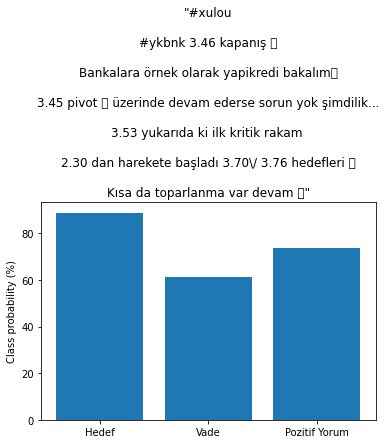

In [567]:
custom_tweet = "#xulou\n\n#ykbnk 3.46 kapanış ✅\n\nBankalara örnek olarak yapikredi bakalım🎈\n\n3.45 pivot 🎯 üzerinde devam ederse sorun yok şimdilik...\n\n3.53 yukarıda ki ilk kritik rakam \n\n2.30 dan harekete başladı 3.70\/ 3.76 hedefleri 🎯\n\nKısa da toparlanma var devam ✅"
preds_df = pd.DataFrame(prediction)
plt.bar(preds_df["entity_group"], 100 * preds_df["score"], color='C0')
plt.title(f'"{custom_tweet}"')
plt.ylabel("Class probability (%)")
plt.show()